In [1]:
import os

import cv2
import torch
import numpy as np
import seaborn as sns
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn.functional import sigmoid
from sklearn.metrics import roc_auc_score, classification_report

from model import ConvNeXtBase
from utils.data import PlumesDataset

sns.set_style()

In [2]:
model = ConvNeXtBase()

In [3]:
state_dict = torch.load("../weights/convnext-80/[BEST-80]--2023-10-11 23:14:05.586214--train-accuracy:0.9943--test-accuracy:0.9500--train-roc-auc:0.9996--test-roc-auc:0.9725--ConvNeXtBase--pretrained:True--batch-size:64--augmented:True--epoch:28")

state_dict = torch.load("../weights/convnext-100/[BEST]--2023-10-12 09:54:07.602590--train-accuracy:0.9907--test-accuracy:0.0000--train-roc-auc:0.9995--test-roc-auc:0.0000--ConvNeXtBase--pretrained:True--batch-size:64--augmented:True--epoch:32")

In [4]:
model.load_state_dict(state_dict)
model.to("cuda")
model.double()

ConvNeXtBase(
  (model): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=128, out_features=512, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=512, out_features=128, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): Layer

In [5]:
test_dataset = PlumesDataset("../data/dataset_split", is_train=False)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [6]:
n_samples = len(test_dataloader.dataset)
correct_predictions = 0

all_targets = list()
predicted_probabilities = list()

model.eval()
with torch.no_grad():
    for X, y_truth in test_dataloader:
        X = X.to("cuda")
        y_truth = y_truth.unsqueeze(1).to("cuda")
        y_pred = sigmoid(model(X))
        correct_predictions += (y_truth == (y_pred >= 0.5)).type(torch.float).sum().item()

        all_targets.extend(y_truth.cpu().detach().numpy().flatten().tolist())
        predicted_probabilities.extend(y_pred.cpu().detach().numpy().flatten().tolist())


accuracy = correct_predictions / n_samples
print(f"Test accuracy: {accuracy: .4f}")

roc_auc = roc_auc_score(all_targets, predicted_probabilities)
print(f"Test ROC-AUC score: {roc_auc: .4f}")

Test accuracy:  0.9875
Test ROC-AUC score:  1.0000


In [7]:
y_pred = (np.array(predicted_probabilities) >= 0.5).astype(np.int32).tolist()
y_truth = np.array(all_targets).astype(np.int32).tolist()

In [8]:
print(classification_report(y_truth, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        40
           1       1.00      0.97      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



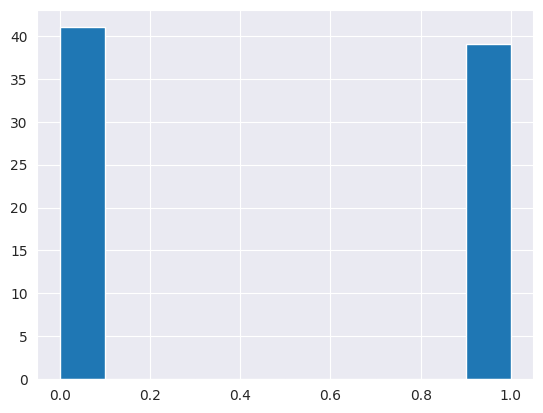

In [9]:
import matplotlib.pyplot as plt

plt.hist(predicted_probabilities)
plt.show()

In [10]:
_BASE_TRANSFORM = transforms.Compose([
    transforms.Lambda(lambda image: torch.from_numpy(image / 65535).unsqueeze(0).repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
import pandas as pd

In [12]:
submission_df = pd.read_csv("../data/submission_test_file.csv")

In [13]:
submission_df.head()

,path,label
0,20230101_methane_mixing_ratio_id_1503.tif,-1
1,20230101_methane_mixing_ratio_id_7352.tif,-1
2,20230101_methane_mixing_ratio_id_7566.tif,-1
3,20230103_methane_mixing_ratio_id_4574.tif,-1
4,20230103_methane_mixing_ratio_id_5449.tif,-1


In [14]:
path_data = "../data/dataset/test_data/images"
predictions = list()
for filename in submission_df.path.values:
    img = cv2.imread(os.path.join(path_data, filename), -1)
    img = _BASE_TRANSFORM(img)
    img = img.to("cuda")
    img = img.unsqueeze(0)
    y_pred = sigmoid(model(img)).item()
    print(f"{filename} - {y_pred}")
    predictions.append(y_pred)

20230101_methane_mixing_ratio_id_1503.tif - 0.0005117894750922085
20230101_methane_mixing_ratio_id_7352.tif - 0.9997676265561708
20230101_methane_mixing_ratio_id_7566.tif - 0.9988491565097264
20230103_methane_mixing_ratio_id_4574.tif - 0.0007691838095602717
20230103_methane_mixing_ratio_id_5449.tif - 0.9996482727830258
20230104_methane_mixing_ratio_id_2384.tif - 0.0005574287210308542
20230105_methane_mixing_ratio_id_4690.tif - 0.8479167272161027
20230106_methane_mixing_ratio_id_7965.tif - 0.00038970196062461463
20230107_methane_mixing_ratio_id_7467.tif - 0.999430267112439
20230107_methane_mixing_ratio_id_9907.tif - 0.0005523654882355065
20230108_methane_mixing_ratio_id_7566.tif - 0.9990506257985919
20230109_methane_mixing_ratio_id_0462.tif - 0.9997463924032451
20230109_methane_mixing_ratio_id_0765.tif - 0.9992355510956822
20230109_methane_mixing_ratio_id_2542.tif - 0.9984194516417202
20230110_methane_mixing_ratio_id_9482.tif - 0.9996995508543276
20230111_methane_mixing_ratio_id_0716.ti

In [15]:
submission_df.label = predictions

In [16]:
submission_df.to_csv("../Output/convnext-100.csv", index=False)